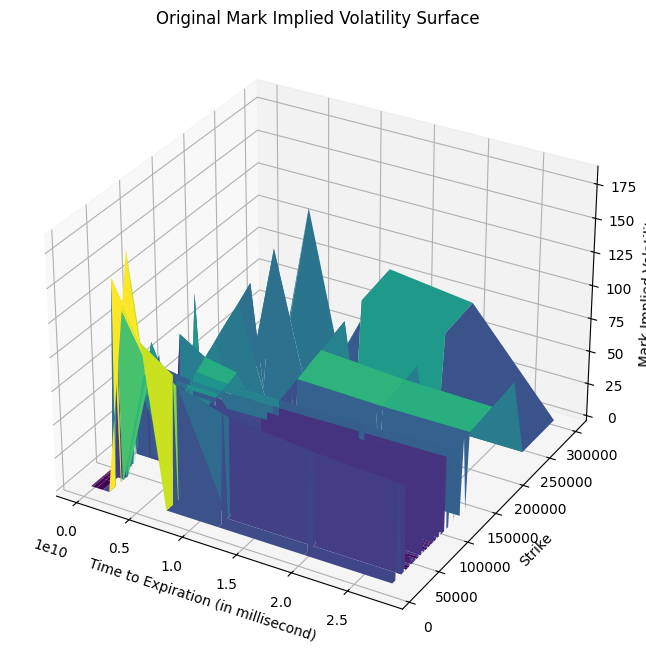

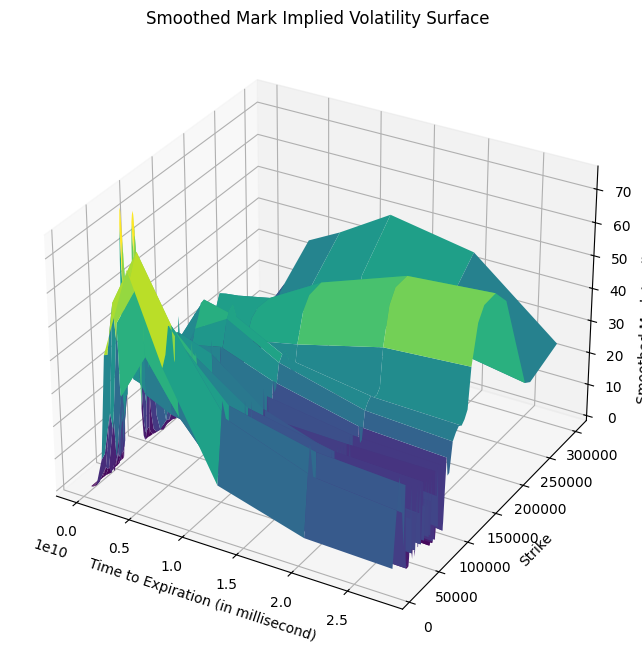

In [12]:
import requests
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time

class DeribitAPI:
    def __init__(self):
        self.base_url = "https://deribit.com/api/v2/public"

    def get_instruments(self, currency="BTC", kind="option"):
        endpoint = f"{self.base_url}/get_instruments"
        params = {
            "currency": currency,
            "kind": kind
        }
        response = requests.get(endpoint, params=params)
        return response.json()["result"]

    def get_order_book(self, instrument_name):
        endpoint = f"{self.base_url}/get_order_book"
        params = {
            "instrument_name": instrument_name
        }
        response = requests.get(endpoint, params=params)
        return response.json()["result"]

def get_implied_volatilities(instruments):
    api = DeribitAPI()
    iv_data = []
    time_now=int(time.time())*1000
    for instrument in instruments:
        order_book = api.get_order_book(instrument["instrument_name"])
        iv_data.append({
            "instrument_name": instrument["instrument_name"],
            "time_to_expiration": instrument["expiration_timestamp"]-time_now,
            "strike": instrument["strike"],
            "implied_volatility": order_book["mark_iv"]
        })
    return iv_data

def visualize_iv_surface(iv_data):
    expirations = sorted(list(set(data["time_to_expiration"] for data in iv_data)))
    strikes = sorted(list(set(data["strike"] for data in iv_data)))

    X, Y = np.meshgrid(expirations, strikes)
    Z = np.zeros_like(X, dtype=float)

    for data in iv_data:
        i = expirations.index(data["time_to_expiration"])
        j = strikes.index(data["strike"])
        Z[j, i] = data["implied_volatility"]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Time to Expiration (in millisecond)')
    ax.set_ylabel('Strike')
    ax.set_zlabel('Mark Implied Volatility')
    ax.set_title('Original Mark Implied Volatility Surface')
    plt.savefig("Original Mark Implied Volatility Surface.png")
    plt.show()

    # Use Gaussian filter to smooth the implied vol
    Z_smoothed = gaussian_filter(Z, sigma=1)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z_smoothed, cmap='viridis')
    ax.set_xlabel('Time to Expiration (in millisecond)')
    ax.set_ylabel('Strike')
    ax.set_zlabel('Smoothed Mark Implied Volatility')
    ax.set_title('Smoothed Mark Implied Volatility Surface')
    plt.savefig("Smoothed Mark Implied Volatility Surface.png")
    plt.show() 

def main():
    api = DeribitAPI()
    instruments = api.get_instruments()
    iv_data = get_implied_volatilities(instruments)
   
    # Save the results to a JSON file in local drive
    with open("C:\\Users\\iv_data.json", "w") as f:
        json.dump(iv_data, f)

    visualize_iv_surface(iv_data)

if __name__ == "__main__":
    main()